## Imports

In [11]:
import sys
!"{sys.executable}" -m pip install aedat

  Using cached aedat-2.2.0-cp312-cp312-macosx_14_0_arm64.whl.metadata (7.0 kB)
Using cached aedat-2.2.0-cp312-cp312-macosx_14_0_arm64.whl (395 kB)

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: pip install --upgrade pip


## Loading the Dataset (CIFAR10DVS)

In [ ]:
import os, random, h5py, numpy as np
from collections import defaultdict
from tqdm import tqdm
from tonic.datasets import CIFAR10DVS

# -------------------------
# Config
# -------------------------
save_dir = "./compressed_datasets_new"
os.makedirs(save_dir, exist_ok=True)

SEED = 123
random.seed(SEED)
np.random.seed(SEED)

num_classes = 10
max_per_class = 300   # adjust as needed

# -------------------------
# Loading CIFAR10-DVS
# -------------------------
print("Loading CIFAR10-DVS (first time may download)…")
cifar = CIFAR10DVS(save_to="./")
print(f"CIFAR10-DVS total: {len(cifar)} | sensor_size={CIFAR10DVS.sensor_size}")

def index_by_class(dataset, num_classes):
    idxs = defaultdict(list)
    for i in tqdm(range(len(dataset)), desc="Indexing by class", leave=False):
        _, y = dataset[i]
        idxs[int(y)].append(i)
    return idxs

def choose_balanced_indices(class_index_dict, num_classes, max_k):
    min_count = min(len(v) for v in class_index_dict.values())
    k = min(max_k, min_count)
    print(f"Per-class cap: {k}")
    chosen = []
    for c in range(num_classes):
        chosen.extend(random.sample(class_index_dict[c], k))
    random.shuffle(chosen)
    return chosen

def to_events_np(ev):
    return np.stack([
        ev["x"].astype(np.float32),
        ev["y"].astype(np.float32),
        ev["t"].astype(np.float32),
        ev["p"].astype(np.float32),
    ], axis=1)

def save_subset_to_h5(dataset, indices, h5_path, sensor_size):
    with h5py.File(h5_path, "w") as h5f:
        for ds_idx in tqdm(indices, desc=f"Writing {os.path.basename(h5_path)}"):
            ev, label = dataset[ds_idx]
            ev_np = to_events_np(ev)
            grp = h5f.create_group(f"sample_{ds_idx}")
            grp.create_dataset("events", data=ev_np, compression="gzip")
            grp.attrs["label"] = int(label)
            grp.attrs["sensor_size"] = tuple(sensor_size)
            grp.attrs["original_event_count"] = len(ev_np)
    print(f"✅ Saved {len(indices)} samples → {h5_path}")

def summarize_h5(h5_path):
    with h5py.File(h5_path, "r") as f:
        total_events = sum(int(f[k].attrs["original_event_count"]) for k in f.keys())
        labels = [f[k].attrs["label"] for k in f.keys()]
    print(f"\nSummary: {os.path.basename(h5_path)}")
    print(f"  Samples: {len(labels)}")
    print(f"  Avg events/sample: {total_events / len(labels):.1f}")
    print(f"  Unique classes: {len(set(labels))}")

idx_by_class = index_by_class(cifar, num_classes)
subset_indices = choose_balanced_indices(idx_by_class, num_classes, max_per_class)

# Save indices
np.save(os.path.join(save_dir, f"cifar10dvs_indices_{len(subset_indices)}.npy"), subset_indices)

# Save raw subset to HDF5
h5_path = os.path.join(save_dir, f"cifar10dvs_uncompressed_{len(subset_indices)}.h5")
save_subset_to_h5(cifar, subset_indices, h5_path, CIFAR10DVS.sensor_size)

# Summary
summarize_h5(h5_path)

Loading CIFAR10-DVS (first time may download)…


11168490496it [45:46, 4066323.30it/s]                                  


Extracting ./CIFAR10DVS/CIFAR10DVS.zip to ./CIFAR10DVS
CIFAR10-DVS total: 10000 | sensor_size=(128, 128, 2)


Per-class cap: 300


Writing cifar10dvs_uncompressed_3000.h5: 100%|██████████| 3000/3000 [03:05<00:00, 16.13it/s]


✅ Saved 3000 samples → ./compressed_datasets_new/cifar10dvs_uncompressed_3000.h5

Summary: cifar10dvs_uncompressed_3000.h5
  Samples: 3000
  Avg events/sample: 203781.9
  Unique classes: 10


## Compression Technique 1 : Grid Based Compression

In [ ]:
import os, h5py, numpy as np, pandas as pd
from tqdm import tqdm

IN_H5  = os.path.join(save_dir, f"cifar10dvs_uncompressed_{len(subset_indices)}.h5")
OUT_H5 = os.path.join(save_dir, f"cifar10dvs_grid_compressed_{len(subset_indices)}.h5")
CSV_OUT = os.path.join(save_dir, f"cifar10dvs_uncompressed_{len(subset_indices)}_grid_summary.csv")

TARGET_RATIO = 8.0          
GRID_SIZE = (40, 40)      

def adaptive_grid_keep_xyti(events_xyti, grid_size, target_ratio, sensor_hw):
    """
    Keep about N/target_ratio events by allocating per-cell quotas
    proportional to cell event counts, and taking the latest ones.

    events_xyti: (N,4) [x,y,t,p] float32
    grid_size: (gx, gy)
    sensor_hw: (H, W)
    returns: indices to keep (np.int64)
    """
    H, W = sensor_hw
    gx, gy = grid_size
    N = events_xyti.shape[0]
    if N == 0:
        return np.empty((0,), dtype=np.int64)

    # target number of events to keep
    target_keep = int(max(1, np.floor(N / target_ratio)))

    # clip coordinates to valid range
    x = np.clip(events_xyti[:, 0].astype(np.int32), 0, W - 1)
    y = np.clip(events_xyti[:, 1].astype(np.int32), 0, H - 1)
    t = events_xyti[:, 2]

    # grid cell sizes
    cw = max(1, W // gx)
    ch = max(1, H // gy)

    # assign each event to a cell id
    cx = np.minimum(x // cw, gx - 1)
    cy = np.minimum(y // ch, gy - 1)
    cell_id = cy * gx + cx  # flatten (cy, cx)

    # counts per cell
    unique_cells, counts = np.unique(cell_id, return_counts=True)

    quotas = np.zeros(gx * gy, dtype=np.int32)
    if counts.sum() > 0:
        raw = (counts / counts.sum()) * target_keep
        quotas[unique_cells] = np.maximum(1, np.floor(raw + 0.5).astype(np.int32))

    total_quota = int(quotas.sum())
    if total_quota > target_keep:
        overflow = total_quota - target_keep
        order = np.argsort(-quotas)
        for idx in order:
            if overflow == 0:
                break
            if quotas[idx] > 0:
                reduce_by = min(quotas[idx], overflow)
                quotas[idx] -= reduce_by
                overflow -= reduce_by
    elif total_quota < target_keep:
        deficit = target_keep - total_quota
        order = np.argsort(-counts) 
        for uc in unique_cells[np.isin(unique_cells, order)]:
            if deficit == 0:
                break
            quotas[uc] += 1
            deficit -= 1

    keep = []
    for uc in unique_cells:
        idx = np.nonzero(cell_id == uc)[0]
        if idx.size == 0:
            continue
        q = int(quotas[uc])
        if q <= 0:
            continue
        if q >= idx.size:
            keep.extend(idx)
        else:
            # take latest by timestamp within that cell
            top_local = np.argpartition(t[idx], -q)[-q:]
            keep.extend(idx[top_local])

    # ensure we don't exceed N (can happen rarely due to rounding)
    if len(keep) > N:
        keep = keep[:N]
    return np.array(keep, dtype=np.int64)

# ----- Run compression with adaptive grid -----
summary = []

with h5py.File(IN_H5, "r") as fin, h5py.File(OUT_H5, "w") as fout:
    first_key = next(iter(fin.keys()))
    sensor_size_attr = fin[first_key].attrs["sensor_size"]
    # Handle (2,H,W) or (H,W)
    if len(sensor_size_attr) == 3:
        H, W = int(sensor_size_attr[1]), int(sensor_size_attr[2])
    else:
        H, W = int(sensor_size_attr[0]), int(sensor_size_attr[1])

    fout.attrs["sensor_size"] = (2, H, W)

    # Create groups
    g_out_events = fout.create_group("events")
    g_out_labels = fout.create_group("labels")
    g_out_discard = fout.create_group("discarded")

    keys = list(fin.keys())
    for k in tqdm(keys, desc="Grid compressing CIFAR10-DVS"):
        grp = fin[k]
        ev = np.array(grp["events"])        
        lbl = int(grp.attrs["label"])

        if ev.shape[0] == 0:
            g_out_events.create_dataset(k, data=ev, compression="gzip")
            g_out_labels.create_dataset(k, data=np.int64(lbl))
            g_out_discard.create_dataset(k, data=ev, compression="gzip")
            summary.append(dict(sample=k, original=0, filtered=0, compression_ratio=np.nan))
            continue

        ev_norm = ev.copy()
        tmax = max(1e-8, ev_norm[:, 2].max())
        ev_norm[:, 2] /= tmax

        keep_idx = adaptive_grid_keep_xyti(
            ev_norm,
            grid_size=GRID_SIZE,
            target_ratio=TARGET_RATIO,
            sensor_hw=(H, W)
        )
        kept = ev[keep_idx] if keep_idx.size else ev[:0]

        # discarded for analysis
        if keep_idx.size:
            mask = np.ones(ev.shape[0], dtype=bool)
            mask[keep_idx] = False
            disc = ev[mask]
        else:
            disc = ev

        # write
        g_out_events.create_dataset(k, data=kept, compression="gzip")
        g_out_labels.create_dataset(k, data=np.int64(lbl))
        g_out_discard.create_dataset(k, data=disc, compression="gzip")

        orig = int(ev.shape[0])
        filt = int(kept.shape[0])
        ratio = (orig / filt) if filt > 0 else np.inf
        summary.append(dict(sample=k, original=orig, filtered=filt, compression_ratio=ratio))

# Save summary
df = pd.DataFrame(summary)
df.to_csv(CSV_OUT, index=False)

mean_ratio = df["compression_ratio"].replace([np.inf, np.nan], np.nan).dropna().mean()
event_reduction = (1.0 - 1.0 / mean_ratio) * 100 if mean_ratio and np.isfinite(mean_ratio) else np.nan
print(f"\n✅ Grid compression (CIFAR10-DVS) complete.")
print(f"• HDF5 saved to: {OUT_H5}")
print(f"• Summary saved to: {CSV_OUT}")
print(f"• Average compression ratio: {mean_ratio:.2f}x")
print(f"• Approx. average event reduction: {event_reduction:.1f}%")

Grid compressing CIFAR10-DVS: 100%|██████████| 3000/3000 [04:15<00:00, 11.74it/s]


✅ Grid compression (CIFAR10-DVS) complete.
• HDF5 saved to: ./compressed_datasets_new/cifar10dvs_grid_compressed_3000.h5
• Summary saved to: ./compressed_datasets_new/cifar10dvs_uncompressed_3000_grid_summary.csv
• Average compression ratio: 8.00x
• Approx. average event reduction: 87.5%


## Compression Technique 2 : DBSCAN Compression

In [ ]:
# === Adaptive DBSCAN compression for CIFAR10-DVS with target ratio ===
import os
import h5py
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.cluster import DBSCAN

# ---- I/O ----
IN_H5  = os.path.join(save_dir, f"cifar10dvs_uncompressed_{len(subset_indices)}.h5")
OUT_H5 = os.path.join(save_dir, f"cifar10dvs_dbscan_adaptive_{len(subset_indices)}.h5")
CSV_OUT = os.path.join(save_dir, f"cifar10dvs_dbscan_adaptive_summary_{len(subset_indices)}.csv")

TARGET_RATIO = 6                 
EPS = 0.8                        
MIN_SAMPLES = 5                  
NORMALIZE_TIME = True            
KEEP_STRATEGY = "recent"        

def select_representatives(ev, labels, quota, strategy="recent"):
    """
    Distribute 'quota' kept events across clusters proportional to cluster size.
    Treat noise (-1) as its own cluster.
    Return indices into 'ev' of points to keep.
    """
    N = len(ev)
    if quota >= N:
        return np.arange(N, dtype=np.int64)

    # Group indices by cluster (including noise)
    clusters = {}
    for i, lbl in enumerate(labels):
        clusters.setdefault(lbl, []).append(i)

    # Remove empty clusters if any
    clusters = {k: np.array(v, dtype=np.int64) for k, v in clusters.items() if len(v) > 0}

    sizes = {k: len(v) for k, v in clusters.items()}
    total = sum(sizes.values())

    kept = []
    per_cluster = {k: 1 for k in clusters.keys()}
    remaining = max(0, quota - len(clusters))

    if remaining > 0:
        # proportional allocation
        props = {k: sizes[k] / total for k in clusters.keys()}
        add = {k: int(np.floor(props[k] * remaining)) for k in clusters.keys()}
        added = sum(add.values())
        if added < remaining:
            order = sorted(clusters.keys(), key=lambda k: sizes[k], reverse=True)
            for k in order[:(remaining - added)]:
                add[k] += 1
        for k in clusters.keys():
            per_cluster[k] += add[k]

    # Now select inside each cluster
    for k, idxs in clusters.items():
        if strategy == "recent":
            # keep most recent by timestamp
            t = ev[idxs, 2]
            order = np.argsort(t)[-per_cluster[k]:]
            kept.extend(idxs[order])
        elif strategy == "random":
            if per_cluster[k] >= len(idxs):
                kept.extend(idxs)
            else:
                kept.extend(np.random.choice(idxs, per_cluster[k], replace=False))
        else:
            kept.extend(idxs[:per_cluster[k]])  # fallback: first K

    return np.asarray(kept, dtype=np.int64)

def dbscan_adaptive(ev_xyti, target_ratio=6, eps=0.8, min_samples=5, normalize_time=True):
    """
    Cluster on (x,y,t), then keep multiple reps per cluster to hit target_ratio.
    Returns kept events (M,4).
    """
    N = ev_xyti.shape[0]
    if N == 0:
        return ev_xyti

    ev = ev_xyti.copy()
    if normalize_time:
        tmax = max(1e-8, ev[:, 2].max())
        ev[:, 2] /= tmax

    coords = ev[:, :3]
    labels = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1).fit(coords).labels_

    # number to keep to hit target ratio
    quota = max(1, int(np.ceil(N / target_ratio)))

    keep_idx = select_representatives(ev_xyti, labels, quota, strategy=KEEP_STRATEGY)
    return ev_xyti[keep_idx]

# ---- run over the subset file ----
summary = []
with h5py.File(IN_H5, "r") as fin, h5py.File(OUT_H5, "w") as fout:
    keys = list(fin.keys())

    ssz = fin[keys[0]].attrs["sensor_size"]
    if len(ssz) == 3:
        H, W = int(ssz[1]), int(ssz[2])
        fout.attrs["sensor_size"] = (2, H, W)
    else:
        H, W = int(ssz[0]), int(ssz[1])
        fout.attrs["sensor_size"] = (2, H, W)

    g_out_e = fout.create_group("events")
    g_out_l = fout.create_group("labels")

    for k in tqdm(keys, desc="DBSCAN (adaptive) CIFAR10-DVS"):
        grp = fin[k]
        ev = np.array(grp["events"], dtype=np.float32)
        lbl = int(grp.attrs["label"])

        kept = dbscan_adaptive(
            ev, target_ratio=TARGET_RATIO,
            eps=EPS, min_samples=MIN_SAMPLES,
            normalize_time=NORMALIZE_TIME
        )

        g_out_e.create_dataset(k, data=kept, compression="gzip")
        g_out_l.create_dataset(k, data=np.int64(lbl))

        orig = int(ev.shape[0])
        filt = int(kept.shape[0])
        ratio = orig / max(1, filt)
        summary.append(dict(sample=k, original=orig, filtered=filt, compression_ratio=ratio))

df = pd.DataFrame(summary)
df.to_csv(CSV_OUT, index=False)

mean_ratio = df["compression_ratio"].replace([np.inf, np.nan], np.nan).dropna().mean()
print("\n✅ DBSCAN (adaptive) compression complete.")
print(f"• HDF5 saved to: {OUT_H5}")
print(f"• Summary saved to: {CSV_OUT}")
print(f"• Average compression ratio: {mean_ratio:.2f}x  (target ~{TARGET_RATIO}x)")

DBSCAN (adaptive) CIFAR10-DVS: 100%|██████████| 3000/3000 [21:14<00:00,  2.35it/s]


✅ DBSCAN (adaptive) compression complete.
• HDF5 saved to: ./compressed_datasets_new/cifar10dvs_dbscan_adaptive_3000.h5
• Summary saved to: ./compressed_datasets_new/cifar10dvs_dbscan_adaptive_summary_3000.csv
• Average compression ratio: 6.00x  (target ~6x)


## Evaluation Metrics for the 2 Compression Methods

              Method  Compression Ratio (x)  Compression Ratio Std  \
0    Grid (Adaptive)                    8.0                    0.0   
1  DBSCAN (Adaptive)                    6.0                    0.0   

   Events per Sample  Events per Sample Std  Data Retention (%)  \
0          25472.049               6513.783              12.500   
1          33964.053               8685.099              16.667   

   Data Retention Std  Compressed Size (MB)  Original Size (MB)  Samples  
0                 0.0              1222.658            9781.529     3000  
1                 0.0              1630.275            9781.529     3000  

✅ Saved summary table → ./compressed_datasets_new/cifar10dvs_grid_vs_dbscan_summary.csv
✅ Saved figure         → ./compressed_datasets_new/cifar10dvs_grid_vs_dbscan_figure.png


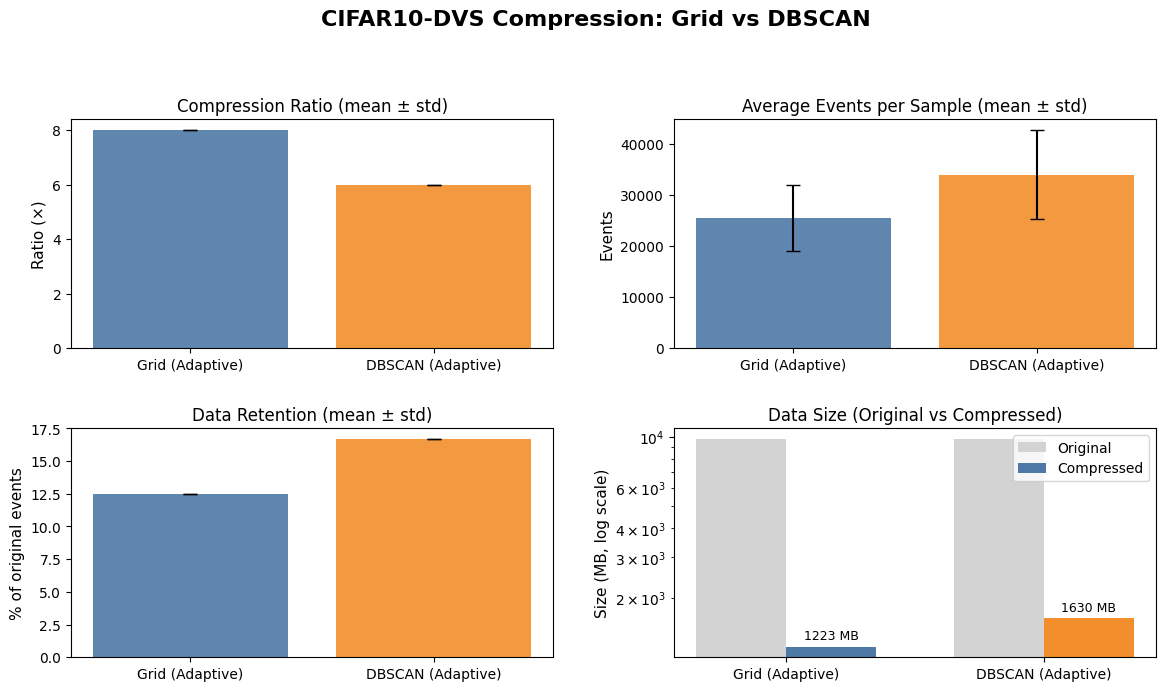

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


GRID_CSV   = os.path.join(save_dir, f"cifar10dvs_uncompressed_{len(subset_indices)}_grid_summary.csv")
DBSCAN_CSV = os.path.join(save_dir, f"cifar10dvs_dbscan_adaptive_summary_{len(subset_indices)}.csv")

# Where to save outputs
OUT_TABLE  = os.path.join(save_dir, "cifar10dvs_grid_vs_dbscan_summary.csv")
OUT_FIG    = os.path.join(save_dir, "cifar10dvs_grid_vs_dbscan_figure.png")

BYTES_PER_EVENT = 16

TITLE = "CIFAR10-DVS Compression: Grid vs DBSCAN"
COLORS = {"Grid":"#4E79A7", "DBSCAN":"#F28E2B"}

def load_results(path):
    df = pd.read_csv(path)
    # standardize column names we need
    cols = {c.lower(): c for c in df.columns}
    for need in ["original","filtered","compression_ratio"]:
        assert any(need == c.lower() for c in df.columns), f"Missing column '{need}' in {path}"
    # Make a consistent set of series
    original = df[[c for c in df.columns if c.lower()=="original"]].iloc[:,0].astype(float)
    filtered = df[[c for c in df.columns if c.lower()=="filtered"]].iloc[:,0].astype(float)
    ratio    = df[[c for c in df.columns if c.lower()=="compression_ratio"]].iloc[:,0].astype(float)
    # Derived
    retention_pct = 100.0 * (filtered / np.where(original>0, original, np.nan))
    return pd.DataFrame({
        "sample": df[[c for c in df.columns if c.lower()=="sample"]].iloc[:,0] if "sample" in cols else np.arange(len(df)),
        "original": original,
        "filtered": filtered,
        "compression_ratio": ratio,
        "retention_pct": retention_pct
    })

df_grid   = load_results(GRID_CSV)
df_dbscan = load_results(DBSCAN_CSV)

def clean(df):
    df = df.copy()
    df = df.replace([np.inf, -np.inf], np.nan).dropna(subset=["compression_ratio","retention_pct","filtered","original"])
    return df

df_grid   = clean(df_grid)
df_dbscan = clean(df_dbscan)


def summarise(df, label):
    total_orig = df["original"].sum()
    total_filt = df["filtered"].sum()
    mean_ratio = (df["compression_ratio"].mean())
    std_ratio  = (df["compression_ratio"].std())
    mean_events = df["filtered"].mean()
    std_events  = df["filtered"].std()
    mean_ret = df["retention_pct"].mean()
    std_ret  = df["retention_pct"].std()
    # sizes
    original_mb   = (total_orig * BYTES_PER_EVENT) / 1e6
    compressed_mb = (total_filt * BYTES_PER_EVENT) / 1e6
    return {
        "Method": label,
        "Compression Ratio (x)": mean_ratio,
        "Compression Ratio Std": std_ratio,
        "Events per Sample": mean_events,
        "Events per Sample Std": std_events,
        "Data Retention (%)": mean_ret,
        "Data Retention Std": std_ret,
        "Compressed Size (MB)": compressed_mb,
        "Original Size (MB)": original_mb,
        "Samples": len(df)
    }

summary_rows = [
    summarise(df_grid, "Grid (Adaptive)"),
    summarise(df_dbscan, "DBSCAN (Adaptive)")
]
df_summary = pd.DataFrame(summary_rows)
df_summary_rounded = df_summary.copy()
for c in df_summary.columns:
    if df_summary[c].dtype.kind in "fc":
        df_summary_rounded[c] = df_summary[c].round(3)

print(df_summary_rounded)
df_summary_rounded.to_csv(OUT_TABLE, index=False)

# ---------- FIGURES ----------
plt.rcParams.update({
    "figure.figsize": (14, 11),
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10
})

fig = plt.figure(constrained_layout=False, figsize=(14, 11))
gs  = fig.add_gridspec(3, 2, height_ratios=[1,1,1], hspace=0.35, wspace=0.25)
fig.suptitle(TITLE, fontsize=16, fontweight="bold", y=0.98)

methods = ["Grid (Adaptive)", "DBSCAN (Adaptive)"]
xpos = np.arange(len(methods))

# Panel A: Compression ratio (mean ± std)
ax = fig.add_subplot(gs[0,0])
means = df_summary["Compression Ratio (x)"].values
errs  = df_summary["Compression Ratio Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5,
       color=[COLORS["Grid"], COLORS["DBSCAN"]], alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods, rotation=0)
ax.set_ylabel("Ratio (×)")
ax.set_title("Compression Ratio (mean ± std)")

# Panel B: Events per sample (mean ± std)
ax = fig.add_subplot(gs[0,1])
means = df_summary["Events per Sample"].values
errs  = df_summary["Events per Sample Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5,
       color=[COLORS["Grid"], COLORS["DBSCAN"]], alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("Events")
ax.set_title("Average Events per Sample (mean ± std)")

# Panel C: Data retention % (mean ± std)
ax = fig.add_subplot(gs[1,0])
means = df_summary["Data Retention (%)"].values
errs  = df_summary["Data Retention Std"].values
ax.bar(xpos, means, yerr=errs, capsize=5,
       color=[COLORS["Grid"], COLORS["DBSCAN"]], alpha=0.9)
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("% of original events")
ax.set_title("Data Retention (mean ± std)")

# Panel D: Data size comparison (log scale with labels)
ax = fig.add_subplot(gs[1,1])
orig_sizes = df_summary["Original Size (MB)"].values
comp_sizes = df_summary["Compressed Size (MB)"].values
width = 0.35
ax.bar(xpos - width/2, orig_sizes, width, color="lightgray", label="Original")
bars = ax.bar(xpos + width/2, comp_sizes, width, color=[COLORS["Grid"], COLORS["DBSCAN"]], label="Compressed")
ax.set_yscale("log")
ax.set_xticks(xpos); ax.set_xticklabels(methods)
ax.set_ylabel("Size (MB, log scale)")
ax.set_title("Data Size (Original vs Compressed)")
ax.legend()
# annotate compressed bars
for b in bars:
    h = b.get_height()
    ax.annotate(f"{h:.0f} MB", xy=(b.get_x()+b.get_width()/2, h),
                xytext=(0,3), textcoords="offset points",
                ha="center", va="bottom", fontsize=9)

print(f"\n✅ Saved summary table → {OUT_TABLE}")
print(f"✅ Saved figure         → {OUT_FIG}")